**Fitting a reward model offline**

In this example, we'll train a vanilla PPO agent on the Brax Ant environment using the "ground truth" reward provided by the environment. We'll then fit a reward model to the resulting clips.

In order to do this, we'll need to "record" a subset of the environment states visited by the agent during the training process. For this we can use the `BraxRecorder` environment wrapper class, which uses JAX host callbacks to efficiently record these states without interrupting Brax's wicked fast all-GPU training loop.

In [ ]:
from brax.envs import create_fn
from brax.training import ppo
from classroom.brax import BraxRecorder
import numpy as np

train_sps = []

def progress(_, metrics):
    train_sps.append(metrics['speed/sps'])

def env_fn(name: str, db_path: str):
    brax_fn = create_fn(env_name=name)
    return lambda *args, **kwargs: BraxRecorder(brax_fn(*args, **kwargs), db_path)


ppo.train(
    environment_fn=env_fn('ant', '~/classroom/ant'), num_timesteps = 30_000_000,
    log_frequency = 10, reward_scaling = .1, episode_length = 1000,
    normalize_observations = True, action_repeat = 1, unroll_length = 5,
    num_minibatches = 32, num_update_epochs = 4, discounting = 0.97,
    learning_rate = 3e-4, entropy_cost = 1e-2, num_envs = 2048,
    batch_size = 1024, progress_fn = progress
)

print(f'train steps/sec: {np.mean(train_sps[1:])}')

If you like, you can now use the Classroom GUI to input your own preferences on the resulting clips. For this example, though, we'll simulate the human preference feedback by stochastically generating preferences based on the ground truth rewards.

In [15]:
from classroom.datasets import InMemoryClipDataset
import jax.numpy as jnp
import numpy as np


ds = InMemoryClipDataset(
    '~/classroom/ant',
    filter_fn=lambda x: len(x.action) == 120,
    transform=lambda x: np.concatenate([x.state.obs, x.action], axis=1)
)

In [16]:
from classroom.datasets import BatchedDataset, SubsetDataset
import numpy as np

indices = np.random.permutation(len(ds))
test_size = round(len(ds) * 0.2)

test = SubsetDataset(ds, indices[:test_size])
val = BatchedDataset(SubsetDataset(ds, indices[test_size:test_size * 2]), 64)
train = BatchedDataset(SubsetDataset(ds, indices[test_size * 2:]), 64)

In [12]:
from edward2.jax.nn import RandomFeatureGaussianProcess# , # SpectralNormalization
from flax.core.scope import VariableDict
import flax.linen as nn
import jax
import jax.numpy as jnp
import optax


class PrefModel(nn.Module):
    hidden_layers: list[int]

    @nn.compact
    def __call__(self, x: jnp.ndarray, eval: bool = False) -> tuple[jnp.ndarray, jnp.ndarray]:
        for size in self.hidden_layers:
            x = SpectralNormalization(nn.Dense(size))(x, training=not eval)
            x = nn.activation.relu(x)
            # x = nn.Dropout(0.1)(x, deterministic=eval)
        
        scores, var = RandomFeatureGaussianProcess(1)(x)
        return jnp.mean(scores.squeeze(-1), axis=-1), var

In [10]:
from typing import Any, Callable, Iterable, Mapping, Optional, Tuple, Union

import flax.core
import flax.linen as nn
import jax
from jax import lax
import jax.numpy as jnp
import numpy as np

# conventional Flax types
Axes = Union[int, Iterable[int]]
Array = Any
Dtype = Any
PRNGKey = Any
Shape = Tuple[int]


def _l2_normalize(x, eps=1e-12):
  return x * jax.lax.rsqrt(jnp.maximum(jnp.square(x).sum(), eps))


class SpectralNormalization(nn.Module):
  """Implements spectral normalization for linear layers.

  In Flax, parameters are immutable so we cannot modify the parameters of
  the input layer during the transformation. As a resolution, we will move
  all parameters of the input layer to this spectral normalization layer.
  During the transformation, we will modify the weight and call the input
  layer with the updated weight.
  For example, the pattern for parameters with a Dense input layer will be
    {"Dense": {"weight": ..., "bias": ...}}
  which matches the pattern in Flax as if "Dense" is a submodule of this
  spectral normalization layer. Name of the input layer can be customized
  using the `layer_name` attribute.

  Note that currently, the implementation with a customized
  ``kernel_apply_kwargs`` attribute only works for Flax's Dense, Conv, Embed
  (or their subclasses) input layers.

  Attributes:
    layer: a Flax layer to apply normalization to.
    iteration: the number of power iterations to estimate weight matrix's
      singular value.
    norm_multiplier: multiplicative constant to threshold the normalization.
      Usually under normalization, the singular value will converge to this
      value.
    u_init: initializer function for the first left singular vectors of the
      kernel.
    v_init: initializer function for the first right singular vectors of the
      kernel.
    kernel_apply_kwargs: updated keyword arguments to clone the input layer. The
      cloned layer represents the linear operator performed by the weight
      matrix. If not specified, that operator follows SN-GAN implementation
      (reference [1]). In particular, for Dense layers the default behavior is
      equivalent to using a cloned layer with no bias (by specifying
      ``kernel_apply_kwargs=dict(use_bias=False)``). With this customization, we
      can have the same implementation (inspried by reference [3]) for different
      interpretations of Conv layers. Also see SpectralNormalizationConv2D for
      an example of using this attribute.
    kernel_name: name of the kernel parameter of the input layer.
    layer_name: name of the input layer.
  """
  layer: nn.Module
  iteration: int = 1
  norm_multiplier: float = 0.95
  u_init: Callable[[PRNGKey, Shape, Dtype],
                   Array] = nn.initializers.normal(stddev=0.05)
  v_init: Callable[[PRNGKey, Shape, Dtype],
                   Array] = nn.initializers.normal(stddev=0.05)
  kernel_apply_kwargs: Optional[Mapping[str, Any]] = None
  # TODO(phandu): Allow users to provide a list of kernel names, so that
  # we can use SN-GAN interpretation for SeparableConv2D layers.
  kernel_name: str = "kernel"
  layer_name: Optional[str] = None

  def _get_singular_vectors(self, initializing, kernel_apply, in_shape, dtype):
    if initializing:
      rng_u = self.make_rng("params")
      rng_v = self.make_rng("params")
      # Interpret output shape (not that this does not cost any FLOPs).
      out_shape = jax.eval_shape(kernel_apply,
                                 jax.ShapeDtypeStruct(in_shape, dtype)).shape
    else:
      rng_u = rng_v = out_shape = None
    u = self.variable("spectral_stats", "u", self.u_init, rng_u, out_shape,
                      dtype)
    v = self.variable("spectral_stats", "v", self.v_init, rng_v, in_shape,
                      dtype)
    return u, v

  @nn.compact
  def __call__(self, inputs: Array, training: bool = True) -> Array:
    """Applies a linear transformation with spectral normalization to the inputs.

    Args:
      inputs: The nd-array to be transformed.
      training: Whether to perform power interations to update the singular
        value estimate.

    Returns:
      The transformed input.
    """
    layer_name = type(
        self.layer).__name__ if self.layer_name is None else self.layer_name
    params = self.param(layer_name,
                        lambda *args: self.layer.init(*args)["params"], inputs)
    w = params[self.kernel_name]

    if self.kernel_apply_kwargs is None:
      # By default, we use the implementation in SN-GAN.
      kernel_apply = lambda x: x @ w.reshape(-1, w.shape[-1]) #@ x
      in_shape = (np.prod(w.shape[:-1]),)
    else:
      # Otherwise, we extract the actual kernel transformation in the input
      # layer. This is useful for Conv2D spectral normalization in [2].
      kernel_apply = self.layer.clone(**self.kernel_apply_kwargs).bind(  # pylint: disable=not-a-mapping
          {"params": {
              self.kernel_name: w
          }})
      # Compute input shape of the kernel operator. This is correct for all
      # linear layers on Flax: Dense, Conv, Embed.
      in_shape = inputs.shape[-w.ndim + 1:-1] + w.shape[-2:-1]

    initializing = self.is_mutable_collection("params")
    u, v = self._get_singular_vectors(initializing, kernel_apply, in_shape,
                                      w.dtype)
    u_hat, v_hat = u.value, v.value
    u_, kernel_transpose = jax.vjp(kernel_apply, v_hat)
    if training and not initializing:
      # Run power iterations using autodiff approach inspired by [3].
      def scan_body(carry, _):
        u_hat, v_hat, u_ = carry
        v_, = kernel_transpose(u_hat)
        v_hat = _l2_normalize(v_)
        u_ = kernel_apply(v_hat)
        u_hat = _l2_normalize(u_)
        return (u_hat, v_hat, u_), None

      (u_hat, v_hat, u_), _ = jax.lax.scan(
          scan_body, (u_hat, v_hat, u_), None, length=self.iteration)
      u.value, v.value = u_hat, v_hat

    sigma = jnp.vdot(u_hat, u_)
    # Bound spectral norm by the `norm_multiplier`.
    sigma = jnp.maximum(sigma / self.norm_multiplier, 1.)
    w_hat = w / jax.lax.stop_gradient(sigma)
    self.sow("intermediates", "w", w_hat)

    # Update params.
    params = flax.core.unfreeze(params)
    params[self.kernel_name] = w_hat
    layer_params = flax.core.freeze({"params": params})
    return self.layer.apply(layer_params, inputs)


In [22]:
from classroom.jax import tree_stack
from flax.training.train_state import TrainState
from scipy.stats import kendalltau
from typing import Iterable, Any


model_schema = PrefModel([32, 16])

#@jax.vmap
def init_state(seed: int) -> TrainState:
    opt = optax.adamw(learning_rate=1e-3, weight_decay=0.01)
    params = model_schema.init(jax.random.PRNGKey(seed), jnp.zeros((120, 95,)))
    return TrainState.create(apply_fn=model_schema.apply, params=params, tx=opt)

# @jax.jit
#@partial(jax.vmap, in_axes=(0, None, None))
def train_step(state: TrainState, data, labels) -> tuple[float, TrainState]:
    def compute_loss(variables: VariableDict):
        scores: Any = model_schema.apply(variables, data, mutable=['spectral_stats', 'intermediates'])
        
        # Sort predicted scores by their GT rewards/ranks, lowest to highest
        print(f"{scores=}")
        scores = scores[jnp.argsort(labels)]

        # We imagine that the GT ranking was generated sequentially in descending
        # order, by sampling *without replacement* from the available options in
        # proportion to exp(scores). The option set shrinks by one every time a
        # choice is made; e.g. the highest ranked option was selected from among the
        # entire set of options, the second highest from the whole set minus the
        # one just picked, etc. This allows us to efficiently compute the log-likelihood
        # of the GT ranking using a log-cumsum-exp trick.
        stabilizer: jnp.ndarray = scores.max()
        log_normalizer = jnp.log(jnp.cumsum(jnp.exp(scores - stabilizer), 0) + 1e-7)

        return -jnp.mean(scores - log_normalizer - stabilizer)
    
    loss, grads = jax.value_and_grad(compute_loss)(state.params)
    state = state.apply_gradients(grads=grads)
    return loss, state

@jax.jit
#@partial(jax.vmap, in_axes=(0, None))
def predict(state: TrainState, data: jnp.ndarray) -> jnp.ndarray:
    return model_schema.apply(state.params, data, eval=True)

class RankCorrelation:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.scores = []
        self.labels = []
    
    def update(self, scores, labels):
        self.scores.append(scores)
        self.labels.append(labels)
    
    def compute(self):
        scores = np.concatenate(self.scores, axis=0)
        labels = np.concatenate(self.labels, axis=0)
        return kendalltau(scores, labels).correlation

rank_corr = RankCorrelation()

def fit(
        state: TrainState,
        train: Iterable[tuple[jnp.ndarray, jnp.ndarray]],
        val: Iterable[tuple[jnp.ndarray, jnp.ndarray]],
    ) -> TrainState:
    last_val_corr = -1.0

    while True:
        rank_corr.reset()
        
        train_losses = []
        for clip_batch, labels in train:
            loss, state = train_step(state, clip_batch, labels)
            train_losses.append(loss)
        
        print(f'train loss: {np.mean(train_losses)}')
        
        for clip_batch, rewards in val:
            scores = predict(state, clip_batch)
            rank_corr.update(np.ravel(scores), np.ravel(rewards))
        
        val_corr = rank_corr.compute()
        print(f"{val_corr:.4f}")
        if val_corr < last_val_corr:
            break
        else:
            last_val_corr = val_corr

    return state

# ensemble = fit(
#     init_state(jnp.arange(1)),
#     list(map(lambda x: tree_stack(x), train)),
#     list(map(lambda x: tree_stack(x), val)),
# )
model = fit(
    init_state(0),
    list(map(lambda x: tree_stack(x), train)),
    list(map(lambda x: tree_stack(x), val))
)

scores=((Traced<ConcreteArray([-0.66490495 -0.3769847  -0.5804374  -0.48676303 -0.7355253  -0.18728714
 -0.37592465 -0.21291791 -0.10526966 -0.5246494  -0.7125758  -0.6990588
 -0.18503511 -0.15917298 -0.4116939  -0.2450304  -0.8072963  -0.15522277
 -0.331909   -0.24940331 -0.18326536 -0.57501364 -0.12913941 -0.1642913
 -0.04606094 -0.22305308 -0.50961685 -0.15558292 -0.16016191 -0.18122183
 -0.23327558 -0.17706686 -0.42623782 -0.64338374 -0.17651793 -0.46526834
 -0.6050941  -0.40268552 -0.16983539 -0.19104081 -0.6130854  -0.23593834
 -0.53559875 -0.2841591  -0.15545645 -0.18776645 -0.13402098 -0.1807275
 -0.39141178 -0.65731144 -0.5713863  -0.6338863  -0.20123416 -0.6860268
 -0.73166615  0.04085185 -0.14005768 -0.3903607  -0.38346145 -0.13440971
 -0.69615334 -0.0686897  -0.63759834 -0.05947705], dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray([-0.66490495, -0.3769847 , -0.5804374 , -0.48676303,
             -0.7355253 , -0.18728714, -0.37592465, -0.21291791,
      

TypeError: only integer scalar arrays can be converted to a scalar index

In [96]:
rank_corr.compute()

0.9799560325876115

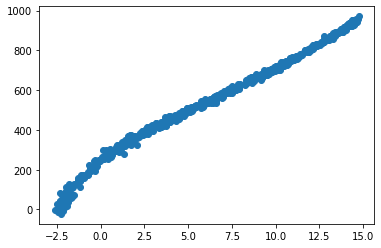

In [102]:
import matplotlib.pyplot as plt

plt.scatter(
    np.concatenate(rank_corr.scores, axis=0),
    np.concatenate(rank_corr.labels, axis=0),
)

In [121]:
clips, scores = tree_stack(list(test))

In [122]:
from scipy.stats import rankdata, kendalltau, spearmanr

gt_ranks = rankdata(scores)
pred_ranks = rankdata(predict(ensemble, clips).mean(axis=0))
kendalltau(gt_ranks, pred_ranks), spearmanr(gt_ranks, pred_ranks)

(KendalltauResult(correlation=0.9628761825579784, pvalue=2.924761009961586e-256),
 SpearmanrResult(correlation=0.9980863471470622, pvalue=0.0))

In [125]:
optax.sigmoid_binary_cross_entropy(predict(ensemble, clips).mean(axis=0), scores).mean()

DeviceArray(0.5028878, dtype=float32)

In [116]:
gt_ranks - pred_ranks

array([-12.,   7.,  15.,  -8.,   2.,  -2.,  -6.,   9., -11.,   6.,  -2.,
         9.,  -1.,  -4.,   1.,   7., -18.,  -7.,   0., -32.,  -9.,   0.,
         2.,  11., -14.,   9., -17.,   0.,   9., -21.,   8.,   3.,  10.,
        -3., -14., -18.,   8.,  -7., -20.,  14.,  15.,  -1.,   3.,  -1.,
         0.,  11.,  -4.,   3.,   1.,  15.,   1., -20.,  -6.,   3.,  15.,
       -11.,  -6.,   0.,   3.,  -7.,   8.,  -9.,   8.,   7.,   9.,  10.,
         1.,  -1.,   3.,  -9.,   6.,   0.,   3.,  28., -13.,   8.,  -3.,
        -1.,  18.,   2.,  -9.,  -2.,   3.,  12.,  -3.,  -1.,   3.,   0.,
       -16.,   6.,   9.,  -6.,  -3.,  20.,   1., -13.,   3.,  -9.,  -1.,
       -10.,   3., -15.,   9., -14.,  -9.,   3.,   5.,  14.,  17.,  -4.,
        -8.,   1., -18.,  -5.,  11.,  22.,  -6.,   1.,  -6.,  20.,  -9.,
         2.,   0., -11.,  19.,   1., -12.,  -2.,  -1.,  -3.,   0.,  -2.,
         8., -19.,  11.,   3.,   6.,  15.,  -4.,  -5.,  -4.,  13., -10.,
         1.,  -4.,   6.,  -1.,  17.,   0.,  14.,   

In [81]:
jax.nn.sigmoid(predict(ensemble, clips).mean(axis=0))

DeviceArray([0.13075374, 0.15615022, 0.13956113, 0.16327901, 0.19661129,
             0.18885909, 0.11370785, 0.15770291, 0.15237252, 0.12477504,
             0.20054507, 0.16200499, 0.17003147, 0.14545158, 0.20719308,
             0.15721044, 0.19883765, 0.17890148, 0.22935244, 0.1852491 ,
             0.19858977, 0.11879966, 0.1428341 , 0.17416711, 0.14564632,
             0.11493433, 0.2298946 , 0.07278071, 0.17754507, 0.21497966,
             0.21492067, 0.15552084], dtype=float32)

In [42]:
from jax.tree_util import tree_map

tree_map(lambda x: x.shape[0], parallel_init_state(jnp.arange(5)))

TrainState(step=5, apply_fn=<bound method Module.apply of PrefModel(
    # attributes
    hidden_layers = [128, 64, 32, 16]
)>, params=FrozenDict({
    params: {
        Dense_0: {
            bias: 5,
            kernel: 5,
        },
        Dense_1: {
            bias: 5,
            kernel: 5,
        },
        Dense_2: {
            bias: 5,
            kernel: 5,
        },
        Dense_3: {
            bias: 5,
            kernel: 5,
        },
        Dense_4: {
            bias: 5,
            kernel: 5,
        },
    },
}), tx=GradientTransformation(init=<function chain.<locals>.init_fn at 0x7f527c47a0e0>, update=<function chain.<locals>.update_fn at 0x7f527c47a200>), opt_state=(ScaleByAdamState(count=5, mu=FrozenDict({
    params: {
        Dense_0: {
            bias: 5,
            kernel: 5,
        },
        Dense_1: {
            bias: 5,
            kernel: 5,
        },
        Dense_2: {
            bias: 5,
            kernel: 5,
        },
        Dense_3: {
  

In [29]:
jnp.arange(5).ndim

1

In [20]:
mega = tree_stack(list(map(lambda x: tree_stack(x), train)))

In [23]:
mega[0].size

34291200